# Manning's n Bulk Analysis

# Manning's n Bulk Sensitivity Analysis

## Overview

This notebook demonstrates **bulk Manning's n sensitivity analysis** for HEC-RAS 2D models with spatially variable roughness. Understanding Manning's n sensitivity is critical for:

- **Model Calibration**: Identifying which roughness zones have greatest impact on results
- **Uncertainty Quantification**: Bounding model predictions based on parameter uncertainty
- **Data Collection Prioritization**: Focusing field surveys on high-sensitivity areas
- **Regulatory Compliance**: Documenting calibration process for permit applications

### What This Notebook Does

1. Extracts a 2D project with Manning's n regions
2. Defines parameter ranges for each roughness zone
3. Systematically varies Manning's n values (bulk modification)
4. Executes HEC-RAS for each parameter combination
5. Extracts results at point of interest
6. Quantifies sensitivity metrics (elasticity, variance contribution)

### LLM Forward Principle: Multi-Level Verifiability

This analysis produces:
- **Parameter Matrix**: CSV of all tested Manning's n combinations
- **Results Table**: Water surface elevations for each scenario
- **Sensitivity Metrics**: Quantitative measures of parameter influence
- **Visualizations**: Tornado diagrams, sensitivity curves
- **HEC-RAS Projects**: Reviewable in GUI for each scenario

### Manning's n Physical Context

**Typical Ranges by Land Cover**:
- **Paved surfaces**: 0.010 - 0.015
- **Mowed grass**: 0.020 - 0.035
- **Pasture/crops**: 0.030 - 0.050
- **Brush/scrub**: 0.050 - 0.120
- **Forest/woodland**: 0.080 - 0.200

**Uncertainty Bounds**:
- Well-characterized: ±20% variation
- Poorly-characterized: ±50% variation or more

### Reference

For Manning's n selection guidance:
- [Chow (1959) Open-Channel Hydraulics: Table 5-6](https://www.amazon.com/Open-Channel-Hydraulics-Ven-Chow/dp/1932846182)
- [HEC-RAS 2D User Manual: Section 3.7 - Manning's n Values](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [USGS TWI 3-A1: Roughness Characteristics of Natural Channels](https://pubs.usgs.gov/twri/twri3-a1/)

For sensitivity analysis methodology:
- [ASCE Manual 110: Sedimentation Engineering - Calibration Guidance](https://ascelibrary.org/)
- [Saltelli et al. (2008) Global Sensitivity Analysis: The Primer](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470725184)

### Analysis Approach

**One-at-a-Time (OAT) Sensitivity**:
- Vary one Manning's n region while holding others constant
- Identify most influential parameters
- Computationally efficient (N parameters = N+1 runs)

**Note**: This bulk approach modifies ALL Manning's n values simultaneously. For individual region sensitivity, see notebook 711 (Multi-Interval).


## Import Libraries and Setup ras-commander

In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    from pathlib import Path
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import (
    init_ras_project, RasExamples, RasPlan, RasCmdr,
    RasGeo, HdfMesh, HdfResultsMesh
)

# Additional imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from shapely.geometry import Point

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: C:\Users\bill\AppData\Roaming\Python\Python313\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [3]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "BaldEagleCrkMulti2D"  # Example project to extract
RAS_VERSION = "6.6"                   # HEC-RAS version

# Manning's Sensitivity Settings
PLAN = "03"                           # Template plan (must have base and regional overrides)
POINT_OF_INTEREST = (2081544, 365715)  # (x, y) coordinates for result extraction
INCLUDE_REGIONAL_OVERRIDES = True     # Adjust regional Manning's values
INCLUDE_BASE_OVERRIDES = True         # Adjust base Manning's values

# Execution Settings
RUN_PARALLEL = True                   # Run plans in parallel
MAX_WORKERS = 4                       # Parallel workers
NUM_CORES = 2                         # Cores per worker


## Note on DataFrame Column Naming

**Important:** The ras-commander library uses simplified column names in DataFrames for Manning's n values:

- DataFrame column:  (no apostrophe)
- HEC-RAS HDF files:  (with apostrophe - official technical term)

This design decision simplifies DataFrame operations by avoiding special characters in column names, 
while HEC-RAS's internal HDF structure retains the technically correct spelling with the apostrophe.

When working with Manning's n values from , always reference the column as  (without apostrophe).

## Define Mannings n Value Ranges

In [4]:
def create_manning_minmax_df():
    """
    Create a dataframe containing minimum and maximum Mannings n values
    based on recommended ranges from literature.
    
    Returns:
        pd.DataFrame: DataFrame with columns for Land Cover Name, min_n, max_n
    """
    # Define the data as a list of dictionaries
    manning_data = [
        {"Land Cover Name": "NoData", "min_n": 0.050, "max_n": 0.070},
        {"Land Cover Name": "Barren Land Rock/Sand/Clay", "min_n": 0.023, "max_n": 0.100},
        {"Land Cover Name": "Cultivated Crops", "min_n": 0.020, "max_n": 0.100},
        {"Land Cover Name": "Deciduous Forest", "min_n": 0.100, "max_n": 0.200},
        {"Land Cover Name": "Developed, High Intensity", "min_n": 0.120, "max_n": 0.200},
        {"Land Cover Name": "Developed, Low Intensity", "min_n": 0.060, "max_n": 0.120},
        {"Land Cover Name": "Developed, Medium Intensity", "min_n": 0.080, "max_n": 0.160},
        {"Land Cover Name": "Developed, Open Space", "min_n": 0.030, "max_n": 0.090},
        {"Land Cover Name": "Emergent Herbaceous Wetlands", "min_n": 0.050, "max_n": 0.120},
        {"Land Cover Name": "Evergreen Forest", "min_n": 0.080, "max_n": 0.160},
        {"Land Cover Name": "Grassland/Herbaceous", "min_n": 0.025, "max_n": 0.070},
        {"Land Cover Name": "Mixed Forest", "min_n": 0.080, "max_n": 0.200},
        {"Land Cover Name": "Open Water", "min_n": 0.025, "max_n": 0.050},
        {"Land Cover Name": "Pasture/Hay", "min_n": 0.025, "max_n": 0.090},
        {"Land Cover Name": "Shrub/Scrub", "min_n": 0.070, "max_n": 0.160},
        {"Land Cover Name": "Woody Wetlands", "min_n": 0.045, "max_n": 0.150}
    ]
    
    # Create DataFrame
    df = pd.DataFrame(manning_data)
    
    # Calculate the midpoint value
    df['mid_n'] = (df['min_n'] + df['max_n']) / 2
    
    # Sort by land cover name
    df = df.sort_values('Land Cover Name').reset_index(drop=True)
    
    # Print summary information
    print(f"Mannings n value ranges for {len(df)} land cover types:")
    print(df)
    
    return df

# Create the Mannings n ranges dataframe
manning_minmax_df = create_manning_minmax_df()

Mannings n value ranges for 16 land cover types:
                 Land Cover Name  min_n  max_n   mid_n
0     Barren Land Rock/Sand/Clay  0.023   0.10  0.0615
1               Cultivated Crops  0.020   0.10  0.0600
2               Deciduous Forest  0.100   0.20  0.1500
3      Developed, High Intensity  0.120   0.20  0.1600
4       Developed, Low Intensity  0.060   0.12  0.0900
5    Developed, Medium Intensity  0.080   0.16  0.1200
6          Developed, Open Space  0.030   0.09  0.0600
7   Emergent Herbaceous Wetlands  0.050   0.12  0.0850
8               Evergreen Forest  0.080   0.16  0.1200
9           Grassland/Herbaceous  0.025   0.07  0.0475
10                  Mixed Forest  0.080   0.20  0.1400
11                        NoData  0.050   0.07  0.0600
12                    Open Water  0.025   0.05  0.0375
13                   Pasture/Hay  0.025   0.09  0.0575
14                   Shrub/Scrub  0.070   0.16  0.1150
15                Woody Wetlands  0.045   0.15  0.0975


## Mannings Bulk Sensitivity Analysis Function

In [5]:
def autoras_mannings_bulk_sensitivity(
    project_folder,
    template_plan,
    manning_minmax_df=None,
    include_regional_overrides=True,
    include_base_overrides=True,
    point_of_interest=None,
    output_folder="Mannings_Bulk_Sensitivity",
    run_parallel=True,
    max_workers=2,
    num_cores=2
):
    """
    Perform Mannings n bulk sensitivity analysis by running model with minimum,
    maximum, and current Mannings n values.
    
    Args:
        project_folder (str): Path to HEC-RAS project folder
        template_plan (str): Plan number to use as template (e.g., "01")
        manning_minmax_df (pd.DataFrame, optional): DataFrame with min/max n values
        include_regional_overrides (bool, optional): Whether to adjust regional
            Mannings values. Default is True.
        include_base_overrides (bool, optional): Whether to adjust base 
            Mannings values. Default is True.
        point_of_interest (tuple or Point, optional): Coordinates for extracting results
        output_folder (str, optional): Name of output folder for results
        run_parallel (bool, optional): Whether to run plans in parallel
        max_workers (int, optional): Number of parallel workers
        num_cores (int, optional): Number of cores per worker
    
    Returns:
        dict: Results of sensitivity analysis
    """
    import time
    from datetime import datetime
    
    # Validate inputs
    if not include_regional_overrides and not include_base_overrides:
        raise ValueError("At least one of include_regional_overrides or include_base_overrides must be True")
    
    # Use default manning_minmax_df if none provided
    if manning_minmax_df is None:
        manning_minmax_df = create_manning_minmax_df()
    
    # Convert point_of_interest to Point if provided
    if point_of_interest is not None and not isinstance(point_of_interest, Point):
        point_of_interest = Point(point_of_interest[0], point_of_interest[1])
    
    # Create timestamp for unique run identifier
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Initialize RAS project using HEC-RAS Version 6.6 (Change if needed)
    print(f"Initializing HEC-RAS project: {project_folder}")
    ras = init_ras_project(project_folder, "6.6")
    
    # Create output directory
    results_dir = Path(project_folder) / output_folder
    results_dir.mkdir(exist_ok=True)
    print(f"Results will be saved to: {results_dir}")
    
    # Display available plans
    print("\nAvailable plans:")
    print(ras.plan_df[['plan_number', 'Plan Title', 'Short Identifier']])
    
    # Verify template plan exists
    if template_plan not in ras.plan_df['plan_number'].values:
        raise ValueError(f"Template plan {template_plan} not found in project")
    
    # Get the geometry number associated with the template plan
    template_geom = ras.plan_df.loc[ras.plan_df['plan_number'] == template_plan, 'geometry_number'].values[0]
    print(f"\nTemplate plan: {template_plan} (Geometry: {template_geom})")
    
    # Get the geometry file path
    geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == template_geom, 'full_path'].values[0]
    
    # Get the original Mannings values
    original_baseoverrides = RasGeo.get_mannings_baseoverrides(geom_path)
    original_regionoverrides = RasGeo.get_mannings_regionoverrides(geom_path)
    
    # Check if regional overrides exist
    has_regional_overrides = not original_regionoverrides.empty
    
    if include_regional_overrides and not has_regional_overrides:
        raise ValueError("include_regional_overrides is True, but no regional overrides found in the model")
    
    # Store the current plan as "current" scenario
    scenarios = [{
        'name': 'Current',
        'plan_number': template_plan,
        'geom_number': template_geom,
        'shortid': f"Current",
        'description': "Current Mannings n Values"
    }]
    
    # Function to create a modified plan with adjusted Mannings values
    def create_modified_plan(name, shortid, description, min_values=False, max_values=False):
        print(f"\nCreating plan: {name} (ShortID: {shortid})")
        print(f"Description: {description}")
        
        # Clone the template plan
        new_plan_number = RasPlan.clone_plan(template_plan, new_plan_shortid=shortid, ras_object=ras)
        
        # Clone the template geometry
        new_geom_number = RasPlan.clone_geom(template_geom, ras_object=ras)
        
        # Set the new plan to use the new geometry
        RasPlan.set_geom(new_plan_number, new_geom_number, ras_object=ras)
        
        # Get the new geometry file path
        new_geom_path = ras.geom_df.loc[ras.geom_df['geom_number'] == new_geom_number, 'full_path'].values[0]
        
        # Adjust base Mannings values if enabled
        if include_base_overrides:
            modified_baseoverrides = original_baseoverrides.copy()
            
            # For each land cover type in the base overrides
            for idx, row in modified_baseoverrides.iterrows():
                land_cover = row['Land Cover Name']
                
                # Find matching land cover in manning_minmax_df
                match = manning_minmax_df[manning_minmax_df['Land Cover Name'] == land_cover]
                
                if not match.empty:
                    current_value = row["Base Mannings n Value"]
                    
                    if min_values:
                        new_value = match['min_n'].values[0]
                    elif max_values:
                        new_value = match['max_n'].values[0]
                    else:
                        new_value = current_value  # No change
                    
                    modified_baseoverrides.loc[idx, "Base Mannings n Value"] = new_value
                    print(f"  Adjusted base override for '{land_cover}': {current_value:.4f} → {new_value:.4f}")
            
            # Apply modified base Mannings values
            RasGeo.set_mannings_baseoverrides(new_geom_path, modified_baseoverrides)
        else:
            # Just copy the original base overrides
            RasGeo.set_mannings_baseoverrides(new_geom_path, original_baseoverrides)
        
        # Adjust regional Mannings values if enabled and they exist
        if include_regional_overrides and has_regional_overrides:
            modified_regionoverrides = original_regionoverrides.copy()
            
            # For each row in the region overrides
            for idx, row in modified_regionoverrides.iterrows():
                land_cover = row['Land Cover Name']
                region_name = row['Region Name']
                
                # Find matching land cover in manning_minmax_df
                match = manning_minmax_df[manning_minmax_df['Land Cover Name'] == land_cover]
                
                if not match.empty:
                    current_value = row["MainChannel"]
                    
                    if min_values:
                        new_value = match['min_n'].values[0]
                    elif max_values:
                        new_value = match['max_n'].values[0]
                    else:
                        new_value = current_value  # No change
                    
                    modified_regionoverrides.loc[idx, "MainChannel"] = new_value
                    print(f"  Adjusted region override for '{land_cover}' in '{region_name}': {current_value:.4f} → {new_value:.4f}")
            
            # Apply modified regional Mannings values
            RasGeo.set_mannings_regionoverrides(new_geom_path, modified_regionoverrides)
        elif has_regional_overrides:
            # Just copy the original region overrides
            RasGeo.set_mannings_regionoverrides(new_geom_path, original_regionoverrides)
        
        # Store scenario details
        return {
            'name': name,
            'plan_number': new_plan_number,
            'geom_number': new_geom_number,
            'shortid': shortid,
            'description': description
        }
    
    # Create minimum and maximum scenarios
    min_scenario = create_modified_plan(
        name="Minimum",
        shortid="Min_n",
        description="Minimum Recommended Mannings n Values",
        min_values=True
    )

    print(f"Minimum Scenario Plan Number: {min_scenario}")
    
    max_scenario = create_modified_plan(
        name="Maximum",
        shortid="Max_n",
        description="Maximum Recommended Mannings n Values",
        max_values=True
    )
    
    print(f"Maximum Scenario Plan Number: {max_scenario}")

    # Add scenarios to list
    scenarios.append(min_scenario)
    scenarios.append(max_scenario)

    print(f"Scenarios: \n{scenarios}")
    
    # Get plan numbers for the new scenarios (excluding template which is already computed)
    plan_numbers = [str(scenario['plan_number']) for scenario in scenarios]
    print(f"Plan Numbers: \n{plan_numbers}")

    # Save scenario information
    scenario_info = pd.DataFrame(scenarios)
    scenario_info_path = results_dir / "scenarios.csv"
    scenario_info.to_csv(scenario_info_path, index=False)
    print(f"\nScenario information saved to: {scenario_info_path}")
    
    # Run the plans (either in parallel or sequentially)
    if run_parallel:
        print(f"\nRunning {len(plan_numbers)} plans in parallel...")
        results = RasCmdr.compute_parallel(
            plan_number=plan_numbers,
            max_workers=max_workers,
            num_cores=num_cores,
            clear_geompre=True
        )
    else:
        print(f"\nRunning {len(plan_numbers)} plans sequentially...")
        results = {}
        for plan_number in plan_numbers:
            print(f"  Running plan {plan_number}...")
            result = RasCmdr.compute_plan(plan_number, num_cores=num_cores, clear_geompre=True)
            results[plan_number] = result
    
    print("\nExecution results:")
    for plan, success in results.items():
        print(f"  Plan {plan}: {'Successful' if success else 'Failed'}")
    
    # Early return if no point of interest is provided
    if point_of_interest is None:
        print("\nNo point of interest provided. Skipping results extraction and analysis.")
        return {
            'scenarios': scenarios,
            'execution_results': results,
            'output_folder': results_dir
        }
    
    # Find nearest mesh cell for result extraction
    # Use the geometry from the first executed plan for cell identification
    geom_hdf_path = None
    for scenario in scenarios:
        geom_number = scenario['geom_number']
        try:
            geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'hdf_path'].values[0]
            break
        except:
            continue
    
    if geom_hdf_path is None:
        print("ERROR: Could not find HDF path for any geometry")
        return {
            'scenarios': scenarios,
            'execution_results': results,
            'output_folder': results_dir
        }
    
    plan_number = scenario['plan_number']

    # Find the nearest mesh cell to the point of interest
    mesh_cells_gdf = HdfMesh.get_mesh_cell_points(plan_number, ras_object=ras)
    
    # Calculate distances from the point to all mesh cells
    distances = mesh_cells_gdf.geometry.apply(lambda geom: geom.distance(point_of_interest))
    
    # Find the index of the minimum distance
    nearest_idx = distances.idxmin()
    
    # Get the cell ID for results extraction
    mesh_cell_for_results = mesh_cells_gdf.loc[nearest_idx, 'cell_id']
    mesh_name = mesh_cells_gdf.loc[nearest_idx, 'mesh_name']
    
    print(f"\nNearest cell ID: {mesh_cell_for_results}")
    print(f"Distance: {distances[nearest_idx]:.2f} units")
    print(f"Mesh area: {mesh_name}")
    
    # Extract and store results
    all_results = {}
    max_ws_values = []
    
    # Get results for each scenario
    for scenario in scenarios:
        plan_number = scenario['plan_number']
        name = scenario['name']
        shortid = scenario['shortid']
        
        # Get the results for this plan
        try:
            results_xr = HdfResultsMesh.get_mesh_cells_timeseries(plan_number, ras_object=ras)
            
            # Extract water surface data for the specific cell
            ws_data = results_xr[mesh_name]['Water Surface'].sel(cell_id=int(mesh_cell_for_results))
            
            # Convert to DataFrame for easier handling
            ws_df = pd.DataFrame({
                'time': ws_data.time.values,
                'water_surface': ws_data.values
            })
            
            # Store in results dictionary
            all_results[plan_number] = {
                'name': name,
                'shortid': shortid,
                'df': ws_df,
                'max_water_surface': ws_df['water_surface'].max()
            }
            
            # Store the maximum water surface value for summary
            max_ws = ws_df['water_surface'].max()
            max_ws_values.append({
                'plan_number': plan_number,
                'name': name,
                'shortid': shortid,
                'max_water_surface': max_ws
            })
            
            print(f"Scenario: {name} ({shortid}): Max Water Surface = {max_ws:.2f}")
            
            # Save time series to CSV
            plan_csv_path = results_dir / f"timeseries_{shortid}.csv"
            ws_df.to_csv(plan_csv_path, index=False)
            print(f"  Time series saved to: {plan_csv_path}")
            
        except Exception as e:
            print(f"Error extracting results for scenario {name}: {str(e)}")
    
    # Create a summary DataFrame for maximum water surface values
    max_ws_df = pd.DataFrame(max_ws_values)
    
    # Save the summary to CSV
    summary_csv_path = results_dir / "max_water_surface_summary.csv"
    max_ws_df.to_csv(summary_csv_path, index=False)
    print(f"\nSummary of maximum water surface elevations saved to: {summary_csv_path}")
    
    # Create and save plots if results were successfully extracted
    if all_results:
        # Plot time series for all scenarios
        plt.figure(figsize=(14, 8))
        
        # Define colors for scenarios
        colors = {'Current': 'black', 'Minimum': 'blue', 'Maximum': 'red'}
        
        # Plot each scenario
        for scenario in scenarios:
            plan_number = scenario['plan_number']
            name = scenario['name']
            
            if plan_number in all_results:
                result = all_results[plan_number]
                df = result['df']
                
                color = colors.get(name, 'gray')
                linestyle = '-' if name == 'Current' else '--'
                linewidth = 2 if name == 'Current' else 1.5
                
                plt.plot(df['time'], df['water_surface'], 
                         label=f"{name} ({result['shortid']})",
                         color=color, linestyle=linestyle, linewidth=linewidth)
        
        # Add plot details
        plt.title(f'Water Surface Sensitivity to Manning\'s Roughness at Cell ID: {mesh_cell_for_results}')
        plt.xlabel('Time')
        plt.ylabel('Water Surface Elevation (ft)')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        # Save the time series plot
        timeseries_plot_path = results_dir / "water_surface_timeseries.png"
        plt.tight_layout()
        plt.savefig(timeseries_plot_path)
        print(f"Time series plot saved to: {timeseries_plot_path}")
        
        # Create bar chart of maximum water surface elevations
        plt.figure(figsize=(10, 6))
        
        # Sort by name for consistent ordering
        max_ws_df_sorted = max_ws_df.sort_values('name')
        
        # Create bar colors
        bar_colors = [colors.get(name, 'gray') for name in max_ws_df_sorted['name']]
        
        # Create bar chart
        plt.bar(max_ws_df_sorted['name'], max_ws_df_sorted['max_water_surface'], color=bar_colors)
        
        # Add values on top of bars
        for i, value in enumerate(max_ws_df_sorted['max_water_surface']):
            plt.text(i, value + 0.1, f'{value:.2f}', ha='center')
        
        # Add plot details
        plt.title('Maximum Water Surface Elevation by Manning\'s Roughness Scenario')
        plt.ylabel('Maximum Water Surface Elevation (ft)')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Save the bar chart
        bar_plot_path = results_dir / "max_water_surface_comparison.png"
        plt.tight_layout()
        plt.savefig(bar_plot_path)
        print(f"Bar chart saved to: {bar_plot_path}")
        
        # Show plots
        plt.show()
    
    # Calculate differences between scenarios
    if len(max_ws_df) >= 2:
        # Get values for each scenario
        try:
            current_ws = max_ws_df.loc[max_ws_df['name'] == 'Current', 'max_water_surface'].values[0]
            min_ws = max_ws_df.loc[max_ws_df['name'] == 'Minimum', 'max_water_surface'].values[0]
            max_ws = max_ws_df.loc[max_ws_df['name'] == 'Maximum', 'max_water_surface'].values[0]
            
            print("\nSensitivity Analysis Summary:")
            print(f"  Current maximum WSE: {current_ws:.2f} ft")
            print(f"  Minimum n maximum WSE: {min_ws:.2f} ft")
            print(f"  Maximum n maximum WSE: {max_ws:.2f} ft")
            print(f"  Range: {max_ws - min_ws:.2f} ft")
            print(f"  Current vs Min: {current_ws - min_ws:.2f} ft")
            print(f"  Current vs Max: {max_ws - current_ws:.2f} ft")
            
            # Calculate the percentage of the range
            if max_ws != min_ws:
                current_position = (current_ws - min_ws) / (max_ws - min_ws) * 100
                print(f"  Current position within range: {current_position:.1f}%")
        except:
            print("Could not calculate differences between scenarios")
    
    # Return results
    return {
        'scenarios': scenarios,
        'execution_results': results,
        'results': all_results if 'all_results' in locals() else None,
        'max_ws_summary': max_ws_df if 'max_ws_df' in locals() else None,
        'mesh_cell_id': mesh_cell_for_results if 'mesh_cell_for_results' in locals() else None,
        'mesh_name': mesh_name if 'mesh_name' in locals() else None,
        'output_folder': results_dir
    }

## Example Usage

In [6]:
# Run this code cell if you want to use the BaldEagleCrkMulti2D Example Project

project_folder = RasExamples.extract_project(PROJECT_NAME, suffix="105")

import os
# Get the current directory for the project path
current_dir = Path(os.getcwd()).resolve()

template_plan = PLAN  # Use PLAN from parameters

# Either as a tuple (x, y) or as a Point object
point_of_interest = POINT_OF_INTEREST  # Use from parameters


2026-01-17 17:44:40 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\bill\AppData\Local\ras-commander\examples\Example_Projects_6_6.zip
2026-01-17 17:44:40 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-17 17:44:40 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-17 17:44:40 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-17 17:44:40 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_105'
2026-01-17 17:44:40 - ras_commander.RasExamples - INFO - Folder 'BaldEagleCrkMulti2D_105' already exists. Deleting existing folder...
2026-01-17 17:44:40 - ras_commander.RasExamples - INFO - Existing folder 'BaldEagleCrkMulti2D_105' has been deleted.
2026-01-17 17:44:41 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105


In [7]:
# Uncomment and Run this Code Cell if you are using your own project
#project_folder = r"C:\Path\To\HEC-RAS\Project"
#template_plan = "01"  # Change to your desired template plan number

# Either as a tuple (x, y) or as a Point object
#point_of_interest = (2081544, 365715)  # Adjust coordinates as needed

In [8]:
# Define a point of interest for result extraction


# Create the Mannings n ranges dataframe (or use the default)
manning_ranges = create_manning_minmax_df()

Mannings n value ranges for 16 land cover types:
                 Land Cover Name  min_n  max_n   mid_n
0     Barren Land Rock/Sand/Clay  0.023   0.10  0.0615
1               Cultivated Crops  0.020   0.10  0.0600
2               Deciduous Forest  0.100   0.20  0.1500
3      Developed, High Intensity  0.120   0.20  0.1600
4       Developed, Low Intensity  0.060   0.12  0.0900
5    Developed, Medium Intensity  0.080   0.16  0.1200
6          Developed, Open Space  0.030   0.09  0.0600
7   Emergent Herbaceous Wetlands  0.050   0.12  0.0850
8               Evergreen Forest  0.080   0.16  0.1200
9           Grassland/Herbaceous  0.025   0.07  0.0475
10                  Mixed Forest  0.080   0.20  0.1400
11                        NoData  0.050   0.07  0.0600
12                    Open Water  0.025   0.05  0.0375
13                   Pasture/Hay  0.025   0.09  0.0575
14                   Shrub/Scrub  0.070   0.16  0.1150
15                Woody Wetlands  0.045   0.15  0.0975


In [9]:
# Execute the template plan first (required for mesh cell identification)
print(f"Executing template plan {template_plan} before sensitivity analysis...")
init_ras_project(project_folder, RAS_VERSION)
RasCmdr.compute_plan(template_plan, num_cores=NUM_CORES)
print(f"Template plan {template_plan} execution complete.")

2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10


Executing template plan 03 before sensitivity analysis...


2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g12
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g12
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g09
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g09
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g13
2026-01-17 17:44:41 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

Template plan 03 execution complete.


2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10
2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g11
2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.

Initializing HEC-RAS project: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105


2026-01-17 17:47:33 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-17 17:47:33 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.rasmap
2026-01-17 17:47:33 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.p03.hdf
2026-01-17 17:47:33 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.p03.hdf
2026-01-17 17:47:33 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagleDamBrk.p03.hdf
2026-01-17 17:47:33 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 2109 characters from HDF
2026-01-17 17:47:33 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path objec

Results will be saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\Mannings_Bulk_Sensitivity

Available plans:
   plan_number                               Plan Title  \
0           13                  PMF with Multi 2D Areas   
1           15              1d-2D Dambreak Refined Grid   
2           17                          2D to 1D No Dam   
3           18                             2D to 2D Run   
4           19                   SA to 2D Dam Break Run   
5           03  Single 2D Area - Internal Dam Structure   
6           04  SA to 2D Area Conn - 2D Levee Structure   
7           02                 SA to Detailed 2D Breach   
8           01             SA to Detailed 2D Breach FEQ   
9           05          Single 2D area with Bridges FEQ   
10          06            Gridded Precip - Infiltration   

            Short Identifier  
0               PMF Multi 2D  
1         1D-2D Refined Grid  
2            2D to 1D No Dam  
3               2D to 2D Ru

2026-01-17 17:47:34 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-17 17:47:34 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-17 17:47:34 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.rasmap
2026-01-17 17:47:34 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.p03.hdf
2026-01-17 17:47:34 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.p03.hdf
2026-01-17 17:47:34 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagleDamBrk.p03.hdf
2026-01-17 17:47:34 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 21

  Adjusted base override for 'NoData': 0.0600 → 0.0500
  Adjusted base override for 'Barren Land Rock/Sand/Clay': 0.0400 → 0.0230
  Adjusted base override for 'Cultivated Crops': 0.0600 → 0.0200
  Adjusted base override for 'Deciduous Forest': 0.1000 → 0.1000
  Adjusted base override for 'Developed, High Intensity': 0.1500 → 0.1200
  Adjusted base override for 'Developed, Low Intensity': 0.1000 → 0.0600
  Adjusted base override for 'Developed, Medium Intensity': 0.0800 → 0.0800
  Adjusted base override for 'Developed, Open Space': 0.0400 → 0.0300
  Adjusted base override for 'Emergent Herbaceous Wetlands': 0.0800 → 0.0500
  Adjusted base override for 'Evergreen Forest': 0.1200 → 0.0800
  Adjusted base override for 'Grassland/Herbaceous': 0.0450 → 0.0250
  Adjusted base override for 'Mixed Forest': 0.0800 → 0.0800
  Adjusted base override for 'Open Water': 0.0350 → 0.0250
  Adjusted base override for 'Pasture/Hay': 0.0600 → 0.0250
  Adjusted base override for 'Shrub/Scrub': 0.0800 → 0.0

2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g13
2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g01
2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g01
2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g03
2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g03
2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g02
2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g02
2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g04
2026-01-17 17:47:35 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g

  Adjusted base override for 'NoData': 0.0600 → 0.0700
  Adjusted base override for 'Barren Land Rock/Sand/Clay': 0.0400 → 0.1000
  Adjusted base override for 'Cultivated Crops': 0.0600 → 0.1000
  Adjusted base override for 'Deciduous Forest': 0.1000 → 0.2000
  Adjusted base override for 'Developed, High Intensity': 0.1500 → 0.2000
  Adjusted base override for 'Developed, Low Intensity': 0.1000 → 0.1200
  Adjusted base override for 'Developed, Medium Intensity': 0.0800 → 0.1600
  Adjusted base override for 'Developed, Open Space': 0.0400 → 0.0900
  Adjusted base override for 'Emergent Herbaceous Wetlands': 0.0800 → 0.1200
  Adjusted base override for 'Evergreen Forest': 0.1200 → 0.1600
  Adjusted base override for 'Grassland/Herbaceous': 0.0450 → 0.0700
  Adjusted base override for 'Mixed Forest': 0.0800 → 0.2000
  Adjusted base override for 'Open Water': 0.0350 → 0.0500
  Adjusted base override for 'Pasture/Hay': 0.0600 → 0.0900
  Adjusted base override for 'Shrub/Scrub': 0.0800 → 0.1

2026-01-17 17:47:36 - ras_commander.RasCmdr - INFO - Created worker folder: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105 [Worker 1]
2026-01-17 17:47:36 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g06
2026-01-17 17:47:36 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g06
2026-01-17 17:47:36 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g08
2026-01-17 17:47:36 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g08
2026-01-17 17:47:36 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g10
2026-01-17 17:47:36 - ras_commander.geom.GeomLateral - INFO - Found 0 SA/2D connections in BaldEagleDamBrk.g10
2026-01-17 17:47:36 - ras_commander.geom.GeomLateral - INFO - Found 0 lateral structures in BaldEagleDamBrk.g11
2026-01-17 17:47:36 - ras_commander.geom.GeomLateral - INFO - 


Execution results:
  Plan 03: Successful
  Plan 07: Successful
  Plan 08: Successful


2026-01-17 17:52:49 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.p03.hdf
2026-01-17 17:52:49 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.p03.hdf
2026-01-17 17:52:49 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\BaldEagleDamBrk.p03.hdf
2026-01-17 17:52:49 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Depth' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:49 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:49 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Velocity X' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-


Nearest cell ID: 943
Distance: 56.22 units
Mesh area: BaldEagleCr


2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNI

Scenario: Current (Current): Max Water Surface = 560.73
  Time series saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\Mannings_Bulk_Sensitivity\timeseries_Current.csv


2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNI

Scenario: Minimum (Min_n): Max Water Surface = 560.11
  Time series saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\Mannings_Bulk_Sensitivity\timeseries_Min_n.csv


2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Water Surface' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Courant' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Cumulative Volume' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Eddy Viscosity' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNING - Variable 'Face Flow Period Average' not found in the HDF file for mesh 'BaldEagleCr'. Skipping.
2026-01-17 17:52:50 - ras_commander.hdf.HdfResultsMesh - WARNI

Scenario: Maximum (Max_n): Max Water Surface = 559.45
  Time series saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\Mannings_Bulk_Sensitivity\timeseries_Max_n.csv

Summary of maximum water surface elevations saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\Mannings_Bulk_Sensitivity\max_water_surface_summary.csv
Time series plot saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\Mannings_Bulk_Sensitivity\water_surface_timeseries.png
Bar chart saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\Mannings_Bulk_Sensitivity\max_water_surface_comparison.png


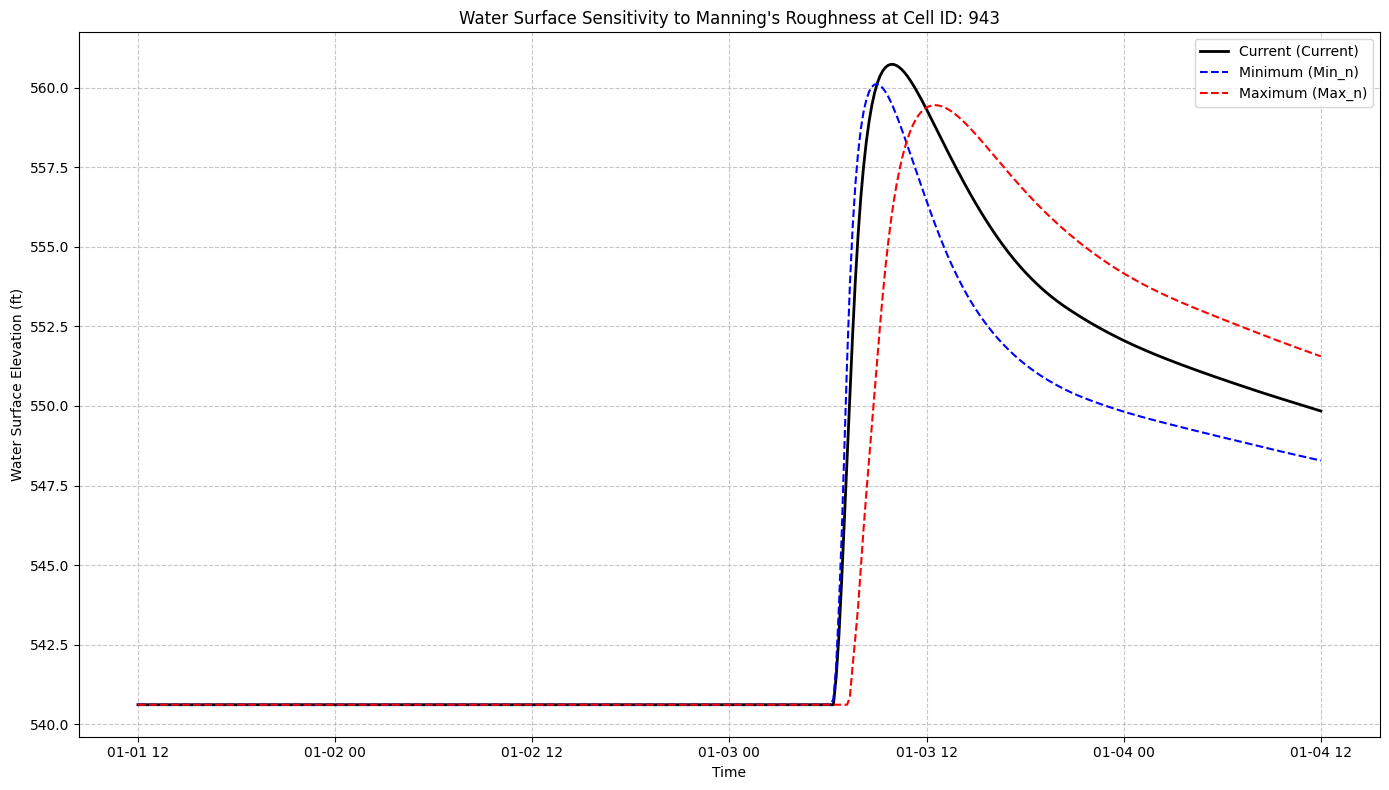

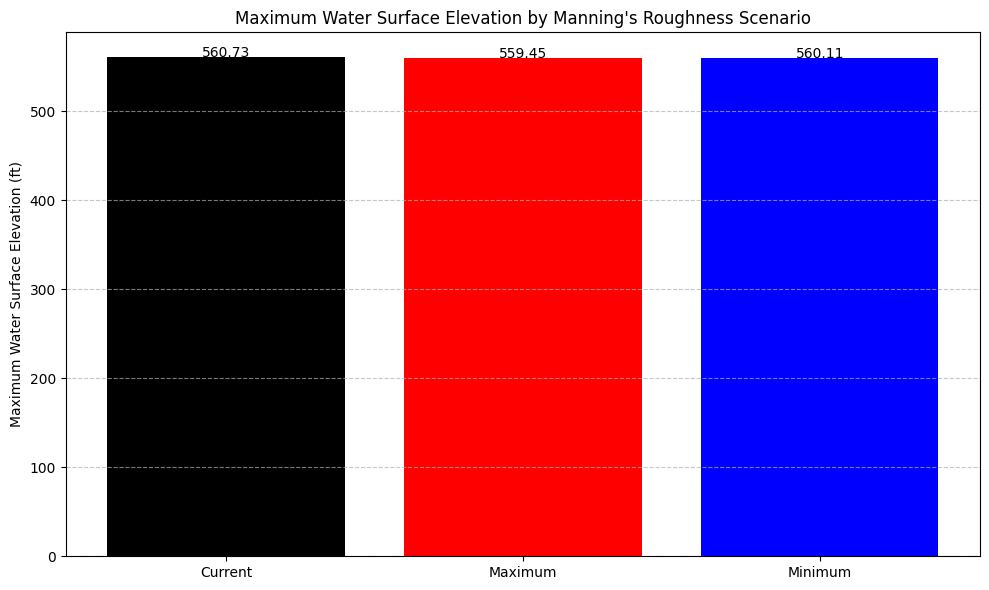


Sensitivity Analysis Summary:
  Current maximum WSE: 560.73 ft
  Minimum n maximum WSE: 560.11 ft
  Maximum n maximum WSE: 559.45 ft
  Range: -0.66 ft
  Current vs Min: 0.62 ft
  Current vs Max: -1.28 ft
  Current position within range: -93.9%


In [10]:
# Example usage of the Mannings Bulk Sensitivity Analysis function



# Optional: Modify the ranges if needed
# manning_ranges.loc[manning_ranges['Land Cover Name'] == 'Open Water', 'min_n'] = 0.03
# manning_ranges.loc[manning_ranges['Land Cover Name'] == 'Open Water', 'max_n'] = 0.04

# Run the analysis
sensitivity_results = autoras_mannings_bulk_sensitivity(
    project_folder=project_folder,
    template_plan=template_plan,
    manning_minmax_df=manning_ranges,
    include_regional_overrides=INCLUDE_REGIONAL_OVERRIDES,
    include_base_overrides=INCLUDE_BASE_OVERRIDES,
    point_of_interest=point_of_interest,
    output_folder="Mannings_Bulk_Sensitivity",
    run_parallel=RUN_PARALLEL,
    max_workers=MAX_WORKERS,
    num_cores=NUM_CORES
)



In [11]:
# Access the results
scenarios = sensitivity_results['scenarios']
max_ws_summary = sensitivity_results['max_ws_summary']
output_folder = sensitivity_results['output_folder']

print(f"\nResults saved to: {output_folder}")


Results saved to: c:\GH\ras-commander\examples\example_projects\BaldEagleCrkMulti2D_105\Mannings_Bulk_Sensitivity


This notebook provides a comprehensive framework for Mannings n sensitivity analysis in HEC-RAS models. It allows you to:

1. Create models with minimum and maximum recommended Mannings n values
2. Run simulations and extract results at locations of interest
3. Visualize and compare water surface elevations across scenarios
4. Understand the sensitivity of your model to roughness parameters

The function gives you flexibility to include or exclude regional and base Mannings overrides, and to customize the analysis based on your specific project needs.